# Assignment 3

In [11]:
# imports
import numpy as np
import scipy.linalg as linag
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from numba import njit

In [12]:
def black_scholes(S, K, T, r, sigma, type='call'):
    """Price Black-Scholes option"""

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return option_price

In [13]:
@njit
def create_tri_diagonal_matrix(a,b,c, size):
    matrix = np.zeros(size)

    np.fill_diagonal(matrix[1:], a)  # superdiagonal
    np.fill_diagonal(matrix, b) # diagonal
    np.fill_diagonal(matrix[:, 1:], c)  # subdiagonal
    
    return matrix

In [14]:
test_matrix = create_tri_diagonal_matrix(1,2,3, (10,10))
print(test_matrix)

[[2. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]]


In [15]:
@njit
def FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet'):
    y_current = init.copy()
    y_next = np.zeros_like(y_current)
    dx = (xmax - xmin) / M
    dt = T / N

    lambda_const = 0.5 * sigma**2 * dt / dx**2

    # Checking the CFL condition value
    cfl_value = lambda_const

    if lambda_const > 0.5:
        ValueError('Warning, CFL condition indicates unstability, choose a different ratio of delta t and delta x')



    # Create the vector coefficients vectors on the tri-diagonal according to the slide 24, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
    a = lambda_const
    b = 1- 2* lambda_const
    c = lambda_const

    
    A = create_tri_diagonal_matrix(a,b,c, (M + 1, M + 1))  # create tridiagonal matrix


    for step in range(N-1):
        if boundary_condition == 'Dirichlet':

            # Only entry we need to modify for boundary condition is j = M, as j=1 will be set to 0 by the boundary conditions and thus can be omitted.
            # Create the vector k which carries modiefied j = M boundary condition according to the slide 25, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
            k = np.zeros(y_current.shape[0])
            tau_n = (N-1) * dt  
            # Apply the computed k value to the last element in y_next, adjusted for the boundary condition
            k[-1] = (np.exp(xmax) - np.exp(-q * tau_n)) * np.exp(0.5 * (q - 1) * xmax + 0.25 * (q + 1)**2 * tau_n)

            # Solve the linear system y_next = A y_current + k
            y_next = A @ y_current + k

        if boundary_condition == 'Neumann':
            # Might implement later
            pass
        
        # Prepare for the next step
        y_current = y_next.copy()
        
    return y_next


In [16]:
@njit
def Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet'):
    y_current = init.copy()
    y_next = np.zeros_like(y_current)
    dx = (xmax - xmin) / M
    dt = T / N

    lambda_const = 0.5 * sigma**2 * dt / dx**2 

    # Checking the CFL condition value
    cfl_value = lambda_const
    
    if lambda_const > 0.5:
        ValueError('Warning, CFL condition indicates unstability, choose a different ratio of delta t and delta x')
        
    # Create the vector coefficients vectors on the tri-diagonal according to the slide 31, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
        
    # Coefficients for A
    a = -lambda_const/2
    b = 1 +  lambda_const
    c = -lambda_const/2

    # Coefficients for B
    d = lambda_const/2
    e = 1 -  lambda_const
    f = lambda_const/2


    A = create_tri_diagonal_matrix(a,b,c, (M + 1, M + 1))  # create tridiagonal matrix A (forward in time)

    B = create_tri_diagonal_matrix(d,e,f, (M + 1, M + 1))  # create tridiagonal matrix B (backward in time)

    for step in range(N-1):
        if boundary_condition == 'Dirichlet':
            # Only entry we need to modify for boundary condition is j = M, as Y0 will be set by 0 by the boundary conditions and thus can be omitted.
            # Create the vector k which carries modiefied j = M boundary condition according to the slide 25, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
            k = np.zeros(y_current.shape[0])
            tau_n = (N-1) * dt  
            # Apply the computed k value to the last element in y_next, adjusted for the boundary condition
            k[-1] = (np.exp(xmax) - np.exp(-q * tau_n)) * np.exp(0.5 * (q - 1) * xmax + 0.25 * (q + 1)**2 * tau_n)

            # Solve the linear system A y_next = B y_current + k
            y_next = np.linalg.solve(A, B @ y_current + k)

        if boundary_condition == 'Neumann':
            # Might implement later
            pass
        
        # Prepare for the next step
        y_current = y_next.copy()
        
    return y_next


In [17]:
def transform_solution(results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q):
    # Generate the grid for x (log(S/K)) and transform results back to option price V
    x = np.linspace(xmin, xmax, M + 1)  # x grid for log(S/K)
    
    # Calculate transformation parameters (should be consistent with PDE transformation)
    a = 0.5 * (q - 1)
    b = 0.25 * (q + 1)**2
    log_SK = np.log(S0 / K)
    sigma2_T2 = (sigma**2 * T) / 2

    # Interpolate the results at the log(S0/K) point
    y_interp_func = interp1d(x, results, kind='linear') 
    y_interpolated = y_interp_func(log_SK)

    # Apply the transformation formula to get the option price V at S0
    V_0 = K * np.exp(-a * log_SK - b * sigma2_T2) * y_interpolated

    return V_0

### 2.0 Obtaining option prices

In [18]:
# Testing

# Scenarios to solve in assignment:  Scenario 1
r = 0.04
sigma = 0.30
S0 = 100
K = 110
T = 1



# Setting up the grid
M =500
N = 500
Smax = 4 * K  # arbitrary choice
Smin = 0.0001  # assuming stock price can't go below 0.0001, set at small number to avoid log(0) errors
xmax = np.log(Smax / K)
xmin = np.log(Smin / K)
dx = (xmax - xmin) / M
dt = T / N


# For later plotting of delta
S_array_scenario_1 = np.linspace(K*np.exp(xmin), K*np.exp(xmax), M+1)


q = (2*r)/(sigma**2)
a = 0.5*(q-1)
b = 0.25*(q+1)**2

# Initial condition (from slide 18, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
x = np.linspace(xmin, xmax, M+1)
init = np.maximum(np.exp(0.5*(q + 1) * x) - np.exp(0.5 *( q - 1) * x), 0)


# Results FTCS
scenario_1_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')

# Results Crank-Nicolson
scenario_1_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')


# Transforming solution FTCS
print('FTCS Scenario 1 call price: ', transform_solution(scenario_1_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))


# Transforming solution Crank-Nicolson
print('Crank-Nicolson Scenario 1 call price:', transform_solution(scenario_1_Crank_results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))

# Black Scholes price
print('Black-scholes Scenario 1 call price:', black_scholes(S0,K,T,r,sigma,type='call'))

FTCS Scenario 1 call price:  9.635616394378369
Crank-Nicolson Scenario 1 call price: 9.634146004583407
Black-scholes Scenario 1 call price: 9.625357828843697


In [19]:
# Scenarios to solve in assignment:  Scenario 2
r = 0.04
sigma = 0.30
S0 = 110
K = 110
T = 1



# Setting up the grid
M =500
N = 500
Smax = 4 * K  # arbitrary choice
Smin = 0.0001  # assuming stock price can't go below 0.0001, set at small number to avoid log(0) errors
xmax = np.log(Smax / K)
xmin = np.log(Smin / K)
dx = (xmax - xmin) / M
dt = T / N

# For later plotting of delta
S_array_scenario_2 = np.linspace(K*np.exp(xmin), K*np.exp(xmax), M+1)




q = (2*r)/(sigma**2)
a = 0.5*(q-1)
b = 0.25*(q+1)**2

# Initial condition (from slide 18, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
x = np.linspace(xmin, xmax, M+1)
init = np.maximum(np.exp(0.5*(q + 1) * x) - np.exp(0.5 *( q - 1) * x), 0)


# Results FTCS
scenario_2_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')

# Results Crank-Nicolson
scenario_2_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')

# Transforming solution FTCS
print('FTCS Scenario 2 call price: ', transform_solution(scenario_2_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))


# Transforming solution Crank-Nicolson
print('Crank-Nicolson Scenario 2 call price:', transform_solution(scenario_2_Crank_results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))

# Black Scholes price
print('Black-scholes Scenario 2 call price:', black_scholes(S0,K,T,r,sigma,type='call'))

FTCS Scenario 2 call price:  15.153754081647524
Crank-Nicolson Scenario 2 call price: 15.153355333032296
Black-scholes Scenario 2 call price: 15.128591111967928


In [20]:
# Scenarios to solve in assignment:  Scenario 3
r = 0.04
sigma = 0.30
S0 = 120
K = 110
T = 1


# Setting up the grid
M =500
N = 500
Smax = 4 * K  # arbitrary choice
Smin = 0.0001  # assuming stock price can't go below 0.0001, set at small number to avoid log(0) errors
xmax = np.log(Smax / K)
xmin = np.log(Smin / K)
dx = (xmax - xmin) / M
dt = T / N

# For later plotting of delta
S_array_scenario_3 = np.linspace(K*np.exp(xmin), K*np.exp(xmax), M+1)


q = (2*r)/(sigma**2)
a = 0.5*(q-1)
b = 0.25*(q+1)**2

# Initial condition (from slide 18, lecture: https://canvas.uva.nl/courses/42579/files/10468265?module_item_id=1984428
x = np.linspace(xmin, xmax, M+1)
init = np.maximum(np.exp(0.5*(q + 1) * x) - np.exp(0.5 *( q - 1) * x), 0)


# Results FTCS
scenario_3_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')

# Results Crank-Nicolson
scenario_3_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')

# Transforming solution FTCS
print('FTCS Scenario 3 call price: ', transform_solution(scenario_3_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))


# Transforming solution Crank-Nicolson
print('Crank-Nicolson Scenario 3 call price:', transform_solution(scenario_3_Crank_results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q))

# Black Scholes price
print('Black-scholes Scenario 3 call price:', black_scholes(S0,K,T,r,sigma,type='call'))

FTCS Scenario 3 call price:  21.882646472135654
Crank-Nicolson Scenario 3 call price: 21.88723263542324
Black-scholes Scenario 3 call price: 21.788808338829327


### 2.1  Plotting convergence as a function of delta x

In [21]:
# Lists for storing

solution_FTCS_scen_1_across_deltax = []
solution_FTCS_scen_2_across_deltax = []
solution_FTCS_scen_3_across_deltax = []

Error_FTCS_scen_1_across_deltax = []
Error_FTCS_scen_2_across_deltax = []
Error_FTCS_scen_3_across_deltax = []

solution_Crank_scen_1_across_deltax = []
solution_Crank_scen_2_across_deltax = []
solution_Crank_scen_3_across_deltax = []

Error_Crank_scen_1_across_deltax = []
Error_Crank_scen_2_across_deltax = []
Error_Crank_scen_3_across_deltax = []


Ms = [100, 200, 300, 400]
# Ms = [200, 400, 600, 800, 1000, 1200, 1400]
dxs = [ (xmax - xmin) / M for M in Ms]
N = 500 # timesteps stay the same
Smax = 4 * K  # arbitrary choice
Smin = 0.0001  # assuming stock price can't go below 0.0001, set at small number to avoid log(0) errors
xmax = np.log(Smax / K)
xmin = np.log(Smin / K)
dx = (xmax - xmin) / M
dt = T / N

# Setting up the grid
for M, dxs in zip(Ms, dxs):

    # Adjusting the grid as it deppends on M
    x = np.linspace(xmin, xmax, M+1)
    init = np.maximum(np.exp(0.5*(q + 1) * x) - np.exp(0.5 *( q - 1) * x), 0)


    # Scenario 1
    r = 0.04
    sigma = 0.30
    S0 = 120
    K = 110
    T = 1
    # Black Scholes price
    scenario_1_BS_results = black_scholes(S0,K,T,r,sigma,type='call')
    # Results FTCS
    scenario_1_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen1_FCTS = transform_solution(scenario_1_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_FTCS_scen_1_across_deltax.append(sol_scen1_FCTS)
    # Results Crank-Nicolson
    scenario_2_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen2_Crank = transform_solution(scenario_1_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_Crank_scen_1_across_deltax.append(sol_scen2_Crank)
    # Errors
    FCTS_scen_1_error = np.abs(scenario_1_BS_results-sol_scen1_FCTS)
    Error_FTCS_scen_1_across_deltax.append(FCTS_scen_1_error)
    Crank_scen_1_error = np.abs(scenario_1_BS_results-sol_scen2_Crank)
    Error_Crank_scen_1_across_deltax.append(Crank_scen_1_error)

    # Scenario 2
    r = 0.04
    sigma = 0.30
    S0 = 110
    K = 110
    T = 1
    # Black Scholes price
    scenario_2_BS_results = black_scholes(S0,K,T,r,sigma,type='call')
    # Results FTCS
    scenario_2_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen2_FCTS = transform_solution(scenario_2_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_FTCS_scen_2_across_deltax.append(sol_scen2_FCTS)
    # Results Crank-Nicolson
    scenario_2_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen2_Crank = transform_solution(scenario_2_Crank_results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_Crank_scen_2_across_deltax.append(sol_scen2_Crank)
    # Errors
    FCTS_scen_2_error = np.abs(scenario_2_BS_results-sol_scen2_FCTS)
    Error_FTCS_scen_2_across_deltax.append(FCTS_scen_2_error)
    Crank_scen_2_error = np.abs(scenario_2_BS_results-sol_scen2_Crank)
    Error_Crank_scen_2_across_deltax.append(Crank_scen_2_error)

    # Scenario 3
    r = 0.04
    sigma = 0.30
    S0 = 120
    K = 110
    T = 1
    # Black Scholes price
    scenario_3_BS_results = black_scholes(S0,K,T,r,sigma,type='call')
    # Results FTCS
    scenario_3_FCTS_results = FTCS_vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen3_FCTS = transform_solution(scenario_3_FCTS_results,  r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_FTCS_scen_3_across_deltax.append(sol_scen3_FCTS)
    # Results Crank-Nicolson
    scenario_3_Crank_results = Crank_Nicolson_Vectorized(init, M, N, r, sigma, xmin, xmax, T, q, boundary_condition = 'Dirichlet')
    sol_scen3_Crank = transform_solution(scenario_3_Crank_results, r, sigma, S0, K, T, Smin, Smax, xmin, xmax, M, N, a, b, q)
    solution_Crank_scen_3_across_deltax.append(sol_scen3_Crank)
    # Errors
    FCTS_scen_3_error = np.abs(scenario_3_BS_results-sol_scen3_FCTS)
    Error_FTCS_scen_3_across_deltax.append(FCTS_scen_3_error)
    Crank_scen_3_error = np.abs(scenario_3_BS_results-sol_scen3_Crank)
    Error_Crank_scen_3_across_deltax.append(Crank_scen_3_error)

 


In [24]:
Error_FTCS_scen_1_across_deltax

[5.911049137885911,
 0.5141057980908101,
 0.28437629471710224,
 0.11339907527803561]

In [27]:

dxs

[0.1529711509888849,
 0.07648557549444245,
 0.05099038366296163,
 0.03824278774722122]

Text(0.5, 1.0, 'Error of FTCS and Crank-Nicolson methods for different dx values')

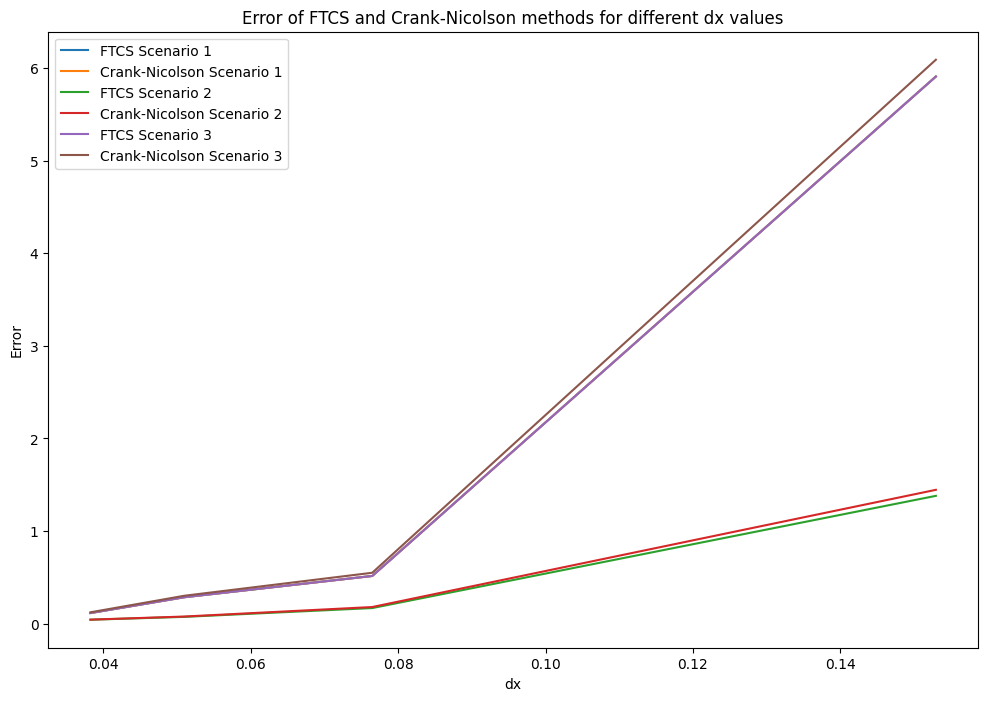

In [28]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(dxs, Error_FTCS_scen_1_across_deltax, label='FTCS Scenario 1')
plt.plot(dxs, Error_Crank_scen_1_across_deltax, label='Crank-Nicolson Scenario 1')
plt.plot(dxs, Error_FTCS_scen_2_across_deltax, label='FTCS Scenario 2')
plt.plot(dxs, Error_Crank_scen_2_across_deltax, label='Crank-Nicolson Scenario 2')
plt.plot(dxs, Error_FTCS_scen_3_across_deltax, label='FTCS Scenario 3')
plt.plot(dxs, Error_Crank_scen_3_across_deltax, label='Crank-Nicolson Scenario 3')
plt.xlabel('dx')
plt.ylabel('Error')
plt.legend()
plt.title('Error of FTCS and Crank-Nicolson methods for different dx values')


### 2.2 Computing Delta

In [ ]:
def compute_delta(option_prices, stock_prices):
    # Compute the derivative of option prices with respect to stock prices
    delta = np.diff(option_prices) / np.diff(stock_prices)
    return delta